In [28]:
import numpy as np

from keras.models import Model, Sequential, clone_model
from keras.layers import Activation, Add, AveragePooling2D, BatchNormalization,\
                         Conv2D, Dense, Input, Flatten, MaxPooling2D, Softmax
from keras.regularizers import l1, l2
from keras.callbacks import ModelCheckpoint, TensorBoard, LearningRateScheduler,\
                            ReduceLROnPlateau, EarlyStopping
from keras.optimizers import Adam
from keras.datasets import cifar10

from pgd_attack import AdversarialExampleGenerator

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

import os
from datetime import datetime
import math

# Restrict GPU memory usage
from keras.backend.tensorflow_backend import set_session
import tensorflow as tf
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
config.gpu_options.visible_device_list = "1"
sess = tf.Session(config=config)
set_session(sess)

In [2]:
model_path = "saved_models/cifar10_ResNet_v1_20_no_rs_lr_reduce_0.031/Apr21_23-46-27/epoch_035_acc_0.408.h5"

config = {
    "num_classes": 10,
    "epochs": 200,
    "batch_size": 64,
    "epsilon": 8 / 255.0,
    "num_validation_samples": 5000
}

In [3]:
####################
# Data preparation #
####################

(x_train, y_train), _ = cifar10.load_data()

# Leave aside a validation set
x_valid = x_train[-config["num_validation_samples"]:]
y_valid = y_train[-config["num_validation_samples"]:]
x_train = x_train[:-config["num_validation_samples"]]
y_train = y_train[:-config["num_validation_samples"]]

# Input image dimensions
input_shape = x_train.shape[1:]

# Normalize data
x_train = x_train.astype("float32") / 255
x_valid = x_valid.astype("float32") / 255

print("x_train shape:", x_train.shape)
print("y_train shape:", y_train.shape)
print(x_train.shape[0], "train samples")
print(x_valid.shape[0], "validation samples")

x_train shape: (45000, 32, 32, 3)
y_train shape: (45000, 1)
45000 train samples
5000 validation samples


In [4]:
def resnet_layer(inputs,
                 num_filters=16,
                 kernel_size=3,
                 strides=1,
                 activation='relu',
                 batch_normalization=True,
                 conv_first=True):
    """2D Convolution-Batch Normalization-Activation stack builder

    # Arguments
        inputs (tensor): input tensor from input image or previous layer
        num_filters (int): Conv2D number of filters
        kernel_size (int): Conv2D square kernel dimensions
        strides (int): Conv2D square stride dimensions
        activation (string): activation name
        batch_normalization (bool): whether to include batch normalization
        conv_first (bool): conv-bn-activation (True) or
            bn-activation-conv (False)

    # Returns
        x (tensor): tensor as input to the next layer
    """
    conv = Conv2D(num_filters,
                  kernel_size=kernel_size,
                  strides=strides,
                  padding='same',
                  kernel_initializer='he_normal',
                  kernel_regularizer=l2(1e-4))

    x = inputs
    if conv_first:
        x = conv(x)
        if batch_normalization:
            x = BatchNormalization()(x)
        if activation is not None:
            x = Activation(activation)(x)
    else:
        if batch_normalization:
            x = BatchNormalization()(x)
        if activation is not None:
            x = Activation(activation)(x)
        x = conv(x)
    return x


def resnet_v1(input_shape, depth, num_classes=10):
    """ResNet Version 1 Model builder [a]

    Stacks of 2 x (3 x 3) Conv2D-BN-ReLU
    Last ReLU is after the shortcut connection.
    At the beginning of each stage, the feature map size is halved (downsampled)
    by a convolutional layer with strides=2, while the number of filters is
    doubled. Within each stage, the layers have the same number filters and the
    same number of filters.
    Features maps sizes:
    stage 0: 32x32, 16
    stage 1: 16x16, 32
    stage 2:  8x8,  64
    The Number of parameters is approx the same as Table 6 of [a]:
    ResNet20 0.27M
    ResNet32 0.46M
    ResNet44 0.66M
    ResNet56 0.85M
    ResNet110 1.7M

    # Arguments
        input_shape (tensor): shape of input image tensor
        depth (int): number of core convolutional layers
        num_classes (int): number of classes (CIFAR10 has 10)

    # Returns
        model (Model): Keras model instance
    """
    if (depth - 2) % 6 != 0:
        raise ValueError("depth should be 6n+2 (eg 20, 32, 44 in [a])")
    # Start model definition.
    num_filters = 16
    num_res_blocks = int((depth - 2) / 6)

    inputs = Input(shape=input_shape)
    x = resnet_layer(inputs=inputs)
    # Instantiate the stack of residual units
    for stack in range(3):
        for res_block in range(num_res_blocks):
            strides = 1
            if stack > 0 and res_block == 0:  # first layer but not first stack
                strides = 2  # downsample
            y = resnet_layer(inputs=x,
                             num_filters=num_filters,
                             strides=strides)
            y = resnet_layer(inputs=y,
                             num_filters=num_filters,
                             activation=None)
            if stack > 0 and res_block == 0:  # first layer but not first stack
                # linear projection residual shortcut connection to match
                # changed dims
                x = resnet_layer(inputs=x,
                                 num_filters=num_filters,
                                 kernel_size=1,
                                 strides=strides,
                                 activation=None,
                                 batch_normalization=False)
            x = Add()([x, y])
            x = Activation("relu")(x)
        num_filters *= 2

    # Add classifier on top.
    # v1 does not use BN after last shortcut connection-ReLU
    x = AveragePooling2D(pool_size=8)(x)
    y = Flatten()(x)
    outputs = Dense(num_classes,
                    activation="softmax",
                    kernel_initializer="he_normal")(y)

    # Instantiate model.
    model = Model(inputs=inputs, outputs=outputs)
    return model

In [5]:
########################
# Model initialisation #
########################

model = resnet_v1(input_shape=input_shape, depth=20)

model.load_weights(model_path)

model.compile(loss="sparse_categorical_crossentropy",
              optimizer=Adam(lr=0.001),
              metrics=["accuracy"])

model.xent_loss = model.total_loss
for loss in model.losses:
    model.xent_loss -= loss

model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 32, 32, 16)   448         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 32, 32, 16)   64          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 32, 32, 16)   0           batch_normalization_1[0][0]      
__________________________________________________________________________________________________
conv2d_2 (

In [6]:
frozen_model = clone_model(model)

frozen_model.load_weights(model_path)

for l in frozen_model.layers[:-1]:
    l.trainable = False

frozen_model.compile(loss="sparse_categorical_crossentropy",
                     optimizer=Adam(lr=0.001),
                     metrics=["accuracy"])

frozen_model.xent_loss = frozen_model.total_loss
for loss in frozen_model.losses:
    frozen_model.xent_loss -= loss

frozen_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 32, 32, 16)   448         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 32, 32, 16)   64          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 32, 32, 16)   0           batch_normalization_1[0][0]      
__________________________________________________________________________________________________
conv2d_2 (

In [7]:
###################
# Data generators #
###################

train_generator = AdversarialExampleGenerator(frozen_model, x_train, y_train,
                                              config["batch_size"],
                                              epsilon=config["epsilon"],
                                              k=8,
                                              a=0.03,
                                              incremental=False)
val_generator =   AdversarialExampleGenerator(frozen_model, x_valid, y_valid,
                                              config["batch_size"],
                                              epsilon=config["epsilon"],
                                              k=40,
                                              a=config["epsilon"] / 10.0,
                                              incremental=False)

In [8]:
#######################
# Initial performance #
#######################

frozen_model.evaluate_generator(val_generator, workers=0, use_multiprocessing=False)

[1.6859858125686646, 0.4054]

In [9]:
#########
# Train #
#########

frozen_model_history = \
    frozen_model.fit_generator(train_generator,
                               validation_data=val_generator,
                               epochs=10,
                               workers=0, # Important for the generators
                               shuffle=False) # Shuffling done in the generators

Epoch 1/10
704/704 [==============================] - 429s 610ms/step - loss: 1.3456 - acc: 0.5275 - val_loss: 1.6958 - val_acc: 0.4002
Epoch 2/10
704/704 [==============================] - 456s 647ms/step - loss: 1.3409 - acc: 0.5286 - val_loss: 1.6907 - val_acc: 0.4062
Epoch 3/10
704/704 [==============================] - 437s 620ms/step - loss: 1.3391 - acc: 0.5278 - val_loss: 1.7003 - val_acc: 0.4028
Epoch 4/10
704/704 [==============================] - 429s 609ms/step - loss: 1.3353 - acc: 0.5300 - val_loss: 1.6985 - val_acc: 0.4044
Epoch 5/10
704/704 [==============================] - 454s 645ms/step - loss: 1.3353 - acc: 0.5293 - val_loss: 1.7024 - val_acc: 0.4038
Epoch 6/10
704/704 [==============================] - 465s 661ms/step - loss: 1.3359 - acc: 0.5284 - val_loss: 1.7102 - val_acc: 0.3962
Epoch 7/10
704/704 [==============================] - 434s 617ms/step - loss: 1.3355 - acc: 0.5281 - val_loss: 1.6990 - val_acc: 0.4022
Epoch 8/10
704/704 [============================

## Replace output layer with stack of dense layers

In [10]:
cloned_model = clone_model(model)

cloned_model.load_weights(model_path)

inputs = cloned_model.input

last_hidden_layer_name = "flatten_1"
output_stack = Sequential([Dense(64, kernel_regularizer=l2(1e-4)), Activation("relu"),
                           Dense(64, kernel_regularizer=l2(1e-4)), Activation("relu"),
                           Dense(64, kernel_regularizer=l2(1e-4)), Activation("relu"),
                           Dense(10), Softmax()])
outputs = output_stack(cloned_model.get_layer(last_hidden_layer_name).output)

complex_output_model = Model(inputs=inputs, outputs=outputs)

for l in complex_output_model.layers[:-2]:
    l.trainable = False

complex_output_model.compile(loss="sparse_categorical_crossentropy",
                             optimizer=Adam(lr=0.001),
                             metrics=["accuracy"])

complex_output_model.xent_loss = complex_output_model.total_loss
for loss in complex_output_model.losses:
    complex_output_model.xent_loss -= loss

complex_output_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 32, 32, 16)   448         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 32, 32, 16)   64          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 32, 32, 16)   0           batch_normalization_1[0][0]      
__________________________________________________________________________________________________
conv2d_2 (

In [11]:
###################
# Data generators #
###################

train_generator = AdversarialExampleGenerator(complex_output_model, x_train, y_train,
                                              config["batch_size"],
                                              epsilon=config["epsilon"],
                                              k=8,
                                              a=0.03,
                                              incremental=False)
val_generator =   AdversarialExampleGenerator(complex_output_model, x_valid, y_valid,
                                              config["batch_size"],
                                              epsilon=config["epsilon"],
                                              k=40,
                                              a=config["epsilon"] / 10.0,
                                              incremental=False)

In [12]:
#######################
# Initial performance #
#######################

complex_output_model.evaluate_generator(val_generator, workers=0, use_multiprocessing=False)

[2.6180956157684325, 0.0536]

In [13]:
#########
# Train #
#########

complex_output_model_history = \
    complex_output_model.fit_generator(train_generator,
                                       validation_data=val_generator,
                                       epochs=10,
                                       workers=0, # Important for the generators
                                       shuffle=False) # Shuffling done in the generators

Epoch 1/10
704/704 [==============================] - 427s 606ms/step - loss: 1.5117 - acc: 0.4740 - val_loss: 1.7489 - val_acc: 0.3892
Epoch 2/10
704/704 [==============================] - 445s 632ms/step - loss: 1.3997 - acc: 0.5094 - val_loss: 1.7841 - val_acc: 0.3734
Epoch 3/10
704/704 [==============================] - 428s 608ms/step - loss: 1.3886 - acc: 0.5130 - val_loss: 1.7659 - val_acc: 0.3906
Epoch 4/10
704/704 [==============================] - 441s 627ms/step - loss: 1.3850 - acc: 0.5131 - val_loss: 1.7635 - val_acc: 0.3848
Epoch 5/10
704/704 [==============================] - 409s 581ms/step - loss: 1.3822 - acc: 0.5139 - val_loss: 1.7757 - val_acc: 0.3886
Epoch 6/10
704/704 [==============================] - 439s 624ms/step - loss: 1.3750 - acc: 0.5177 - val_loss: 1.7325 - val_acc: 0.3914
Epoch 7/10
704/704 [==============================] - 406s 577ms/step - loss: 1.3725 - acc: 0.5184 - val_loss: 1.7566 - val_acc: 0.3950
Epoch 8/10
704/704 [============================

In [17]:
figures_dir = "figures"
if not os.path.exists(figures_dir):
    os.makedirs(figures_dir)

In [54]:
def latexify(fig_width=None, fig_height=None, columns=1):
    """Set up matplotlib's RC params for LaTeX plotting.
    Call this before plotting a figure.

    Parameters
    ----------
    fig_width : float, optional, inches
    fig_height : float,  optional, inches
    columns : {1, 2}
    """

    # code adapted from http://www.scipy.org/Cookbook/Matplotlib/LaTeX_Examples

    # Width and max height in inches for IEEE journals taken from
    # computer.org/cms/Computer.org/Journal%20templates/transactions_art_guide.pdf

    assert(columns in [1,2])

    if fig_width is None:
        fig_width = 3.39 if columns==1 else 6.9 # width in inches

    if fig_height is None:
        golden_mean = (math.sqrt(5)-1.0)/2.0    # Aesthetic ratio
        fig_height = fig_width*golden_mean # height in inches
    
    MAX_HEIGHT_INCHES = 8.0
    if fig_height > MAX_HEIGHT_INCHES:
        print("WARNING: fig_height too large:" + fig_height + 
              "so will reduce to" + MAX_HEIGHT_INCHES + "inches.")
        fig_height = MAX_HEIGHT_INCHES

    params = {'backend': 'ps',
              'text.latex.preamble': ["\\usepackage[lf,minionint,footnotefigures]{MinionPro}"],
              'axes.labelsize': 8, # fontsize for x and y labels (was 10)
              'axes.titlesize': 8,
#               'text.fontsize': 8, # was 10
              'legend.fontsize': 8, # was 10
              'xtick.labelsize': 8,
              'ytick.labelsize': 8,
              'text.usetex': True,
              'figure.figsize': [fig_width, fig_height],
              'font.family': 'serif',
              'mathtext.default': 'regular'
    }

    matplotlib.rcParams.update(params)

%matplotlib inline

latexify()

In [55]:
def save_plot(data,
              min_y=None,
              max_y=None,
              x_label="Epoch",
              y_label="Accuracy",
              y_is_percent=False,
              y_is_log=False,
              y_ticks=None,
              legend=None,
              output="fig.pdf"):
    if min_y is not None or max_y is not None:
        plt.gca().set_ylim([min_y, max_y])
    for i, series in enumerate(data):
        x, y = zip(*series)
        if legend is None:
            plt.plot(x, y, marker="o", markersize=2)
        else:
            plt.plot(x, y, marker="o", markersize=2, label=legend[i])
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    if legend is not None:
        plt.legend()
    plt.grid(True, "both", linestyle="dotted")
    plt.gca().xaxis.set_major_locator(ticker.MultipleLocator(1.0))
    if y_is_percent:
        plt.gca().yaxis.set_major_formatter(ticker.PercentFormatter(decimals=0))
    if y_is_log:
        plt.yscale("log")
    if y_ticks is not None:
        plt.yticks(y_ticks)
#     plt.tight_layout()
    plt.savefig(os.path.join(figures_dir, output), bbox_inches="tight", pad_inches=0)

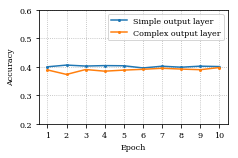

In [57]:
data = [
    zip(range(1, 11), frozen_model_history.history["val_acc"]),
    zip(range(1, 11), complex_output_model_history.history["val_acc"]),
]

legend = ["Simple output layer", "Complex output layer"]

save_plot(data, legend=legend, min_y=0.2, max_y=0.6, output="output_globally_optimal.pdf")